In [1]:
import matplotlib.pyplot as plt
import numpy as np
from quantecon import compute_fixed_point
from scipy.optimize import fminbound

In [8]:
def bellman_operator(w, grid, beta, u, f, shocks, compute_policy=0):
    # === Apply linear interpolation to w === #
    w_func = lambda x: np.interp(x, grid, w)

    Tw = np.empty_like(w)

    if compute_policy:
        sigma = np.empty_like(w)

    # == set Tw[i] = max_c { u(c) + beta E w(f(y  - c) z)} == #
    for i, y in enumerate(grid):
        def objective(c):
            return - u(c) - beta * np.mean(w_func(f(y - c) * shocks))
        c_star = fminbound(objective, 1e-10, y)
        if compute_policy:
            sigma[i] = c_star
        Tw[i] = - objective(c_star)

    if compute_policy:
        return Tw, sigma
    else:
        return Tw

In [3]:
alpha = 0.4
beta = 0.96
mu = 0
s = 0.1

def compute_v_star(y, alpha, beta, mu, s):
        ab = alpha * beta
        c1 = np.log(1 - ab) / (1 - beta)
        c2 = (mu + alpha * np.log(ab)) / (1 - alpha)
        c3 = 1 / (1 - beta)
        c4 = 1 / (1 - ab)
        return c1 + c2 * (c3 - c4) + c4 * np.log(y)

In [4]:
grid_max = 4         # Largest grid point
grid_size = 200      # Number of grid points
grid = np.linspace(1e-5, grid_max, grid_size)

shock_size = 250     # Number of shock draws in Monte Carlo integral
shocks = np.exp(mu + s * np.random.randn(shock_size))

In [5]:
%matplotlib inline

In [6]:
def simulate_og(sigma, y0 = 0.1, ts_length=100):
    '''
    Compute a time series given consumption policy sigma.
    '''
    y = np.empty(ts_length)
    xi = np.random.randn(ts_length)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - sigma(y[t]))**alpha * np.exp(mu + s * xi[t+1])
    return y

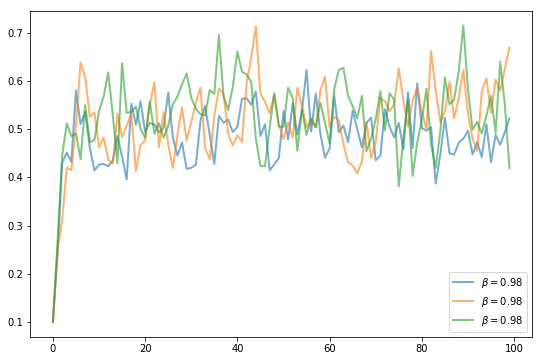

In [11]:
Y = []
for beta in (0.9, 0.94, 0.98):

    initial_w = 5 * np.log(grid)

    v_star_approx = compute_fixed_point(bellman_operator,
                                        initial_w,
                                        1e-5,  # error_tol
                                        500,   # max_iter
                                        False,  # verbose
                                        5,     # print_skip
                                        'iteration',
                                        grid,
                                        beta,
                                        np.log,
                                        lambda k: k**alpha,
                                        shocks,
                                        compute_policy=False)

    Tw, sigma = bellman_operator(v_star_approx,
                            grid,
                            beta,
                            np.log,
                            lambda k: k**alpha,
                            shocks,
                            compute_policy=True)

    sigma_func = lambda x: np.interp(x, grid, sigma)
    y = simulate_og(sigma_func)
    Y.append(y)

#-Generate Plot-#
fig, ax = plt.subplots(figsize=(9, 6))
for y in Y:
    ax.plot(y, lw=2, alpha=0.6, label=r'$\beta = {}$'.format(beta))
ax.legend(loc='lower right')

# Dask

In [13]:
import dask

In [29]:
#Note: This is not working due to dask warning about unspecified lenghts and not beeing iterable.
#Need to understand this issue more closely.

Y = []
for beta in (0.9, 0.94, 0.98):

    initial_w = 5 * np.log(grid)

    v_star_approx = compute_fixed_point(bellman_operator,
                                    initial_w,
                                    1e-5,   # error_tol
                                    500,    # max_iter
                                    False,  # verbose
                                    5,      # print_skip
                                    'iteration',
                                    grid,
                                    beta,
                                    np.log,
                                    lambda k: k**alpha,
                                    shocks,
                                    compute_policy=False)

    Tw, sigma = dask.delayed(bellman_operator)(v_star_approx,
                            grid,
                            beta,
                            np.log,
                            lambda k: k**alpha,
                            shocks,
                            compute_policy=True)

    sigma_func = dask.delayed(lambda x: np.interp(x, grid, sigma))
    y = dask.delayed(simulate_og)(sigma_func)
    Y.append(y)

TypeError: Delayed objects of unspecified length are not iterable

In [ ]:
Y = [dask.compute(Y*)]

In [35]:
for y in Y:
    ax.plot(y, lw=2, alpha=0.6, label=r'$\beta = {}$'.format(beta))
ax.legend(loc='lower right')

/home/mmcky/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
